In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import tifffile as tf
from glob import glob

from skimage import segmentation
from scipy import ndimage, spatial
from sklearn import neighbors
from importlib import reload
import utils

#wall = 255 - tf.imread(wsrc + 'removing_root_from_nodule.tif')[:,:,0]
#wcoords = np.asarray(np.nonzero(wall > 250))
#rcoords = np.asarray(np.nonzero( (wall < 250) & (wall > 50) ) )
#filename = wsrc + 'removing_root_from_nodule.csv'
#np.savetxt(filename, hull.astype(int), fmt='%d', delimiter=',', header='X,Y', comments='')

In [2]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
ksrc = '../kde/'
dst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

sample = 'D2'
ksrc += sample + os.sep
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
#X, Y = np.meshgrid(range(wall.shape[1]), range(wall.shape[0]))
#coords = np.column_stack( (X.ravel(), Y.ravel()) )
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)

print('Detected',cellnum,'cells')
wcoords = np.asarray(np.nonzero(~wall))

Detected 2937 cells


In [3]:
filename = wsrc + 'removing_root_from_nodule.csv'
rcoords = np.loadtxt(filename, dtype=int, delimiter=',', skiprows=1)
convexhull = spatial.ConvexHull(rcoords)
hull = convexhull.points[convexhull.vertices]

# A is shape (f, d) and b is shape (f, 1).
A, b = convexhull.equations[:, :-1], convexhull.equations[:, -1:]
eps = np.finfo(np.float32).eps

def contained(x):
  # The hull is defined as all points x for which Ax + b <= 0.
  # We compare to a small positive value to account for floating
  # point issues.
  #
  # Assuming x is shape (m, d), output is boolean shape (m,).
  return np.all(np.asarray(x) @ A.T + b.T < eps, axis=1)

coms = metacell.loc[:, ['ndimage_comX', 'ndimage_comY']].values
inhull = contained(coms)
inhull[0] = False

#foo = metacell.loc[:, ['orig_cellID', 'orig_comX', 'orig_comY']]
#foo['inhull'] = inhull
#foo.to_csv(wsrc + 'inside_ring_hull.csv', index=False)

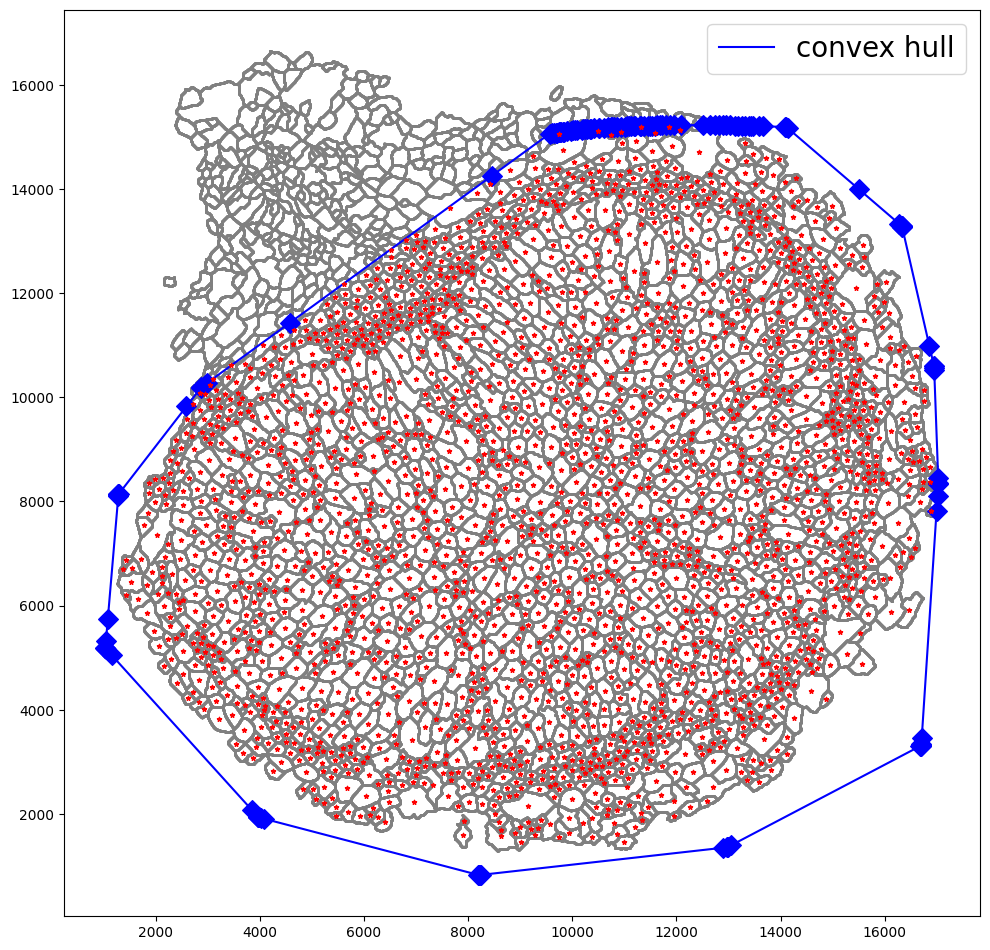

In [14]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=1, c='gray', zorder=1)
ax[0].plot(hull[:,0], hull[:,1], c='b', zorder=2, label='convex hull')
ax[0].scatter(hull[:,0], hull[:,1], marker='D', s=100, c='blue', zorder=3)
ax[0].scatter(coms[inhull,0], coms[inhull, 1], marker='*', s=10, c='r', zorder=4)
ax[0].legend(fontsize=fs)

ax[0].set_aspect('equal')
fig.tight_layout();

#plt.savefig(wsrc + 'inside_ring_hull.png', dpi=200, format='png', bbox_inches='tight')

In [4]:
wall = np.zeros(label.shape, dtype=bool)

for cidx in metacell.loc[inhull].index[1:].values:
    wall[css[cidx-1]][ label[css[cidx-1]] == cidx] = True

its = 8
wall = ndimage.binary_dilation(wall, struc2, iterations = its, border_value=0)
wall = ndimage.binary_fill_holes(wall)
wall = ndimage.binary_erosion(wall, struc2, iterations = its//2, border_value=1)

border = utils.borderize(wall)
border = np.asarray(np.nonzero(border))

In [14]:
convexhull = spatial.ConvexHull(np.flip(border.T, axis=1))
bhull = convexhull.points[convexhull.vertices].astype(int)

In [6]:
A, b = convexhull.equations[:, :-1], convexhull.equations[:, -1:]
eps = np.finfo(np.float32).eps
#np.all(coords @ A.T + b.T < eps, axis=1)

In [ ]:
ch = np.zeros(wall.shape, dtype=bool)
for i in range(bhull[:,1].min()-1 , bhull[:,1].max()+1):
    ch[i] = np.all(np.column_stack((np.arange(ch.shape[1]),np.full(ch.shape[1],i))) @ A.T + b.T < eps, axis=1)
    if i % 2000 == 0:
        print(i)

In [16]:
edt = ndimage.distance_transform_edt(ch)

In [31]:
nonedt = ndimage.distance_transform_edt(~ch)

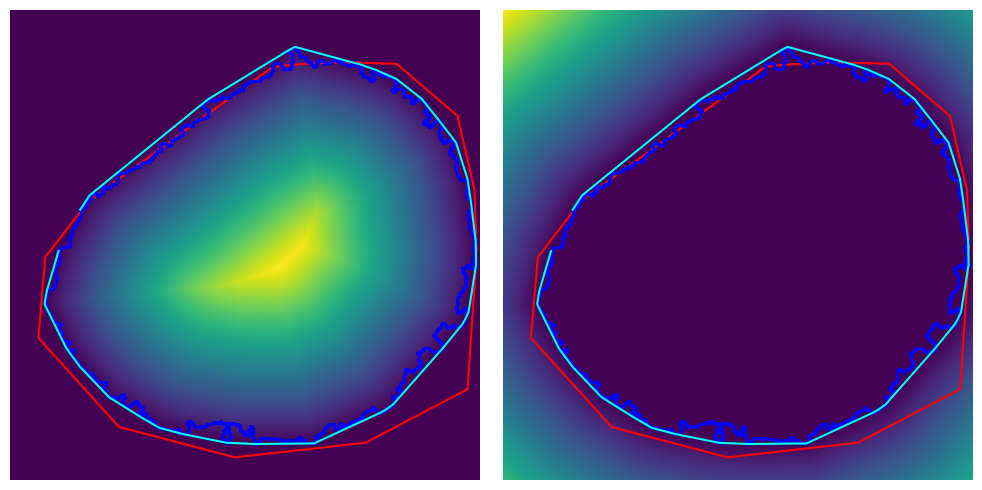

In [32]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(edt, origin='lower')
ax[1].imshow(nonedt, origin='lower')

for i in range(len(ax)):
    ax[i].plot(hull[:,0], hull[:,1], c='r', zorder=2)
    ax[i].scatter(border[1], border[0], c='b', marker='.', s=1, zorder=3)
    ax[i].plot(bhull[:,0], bhull[:,1], c='cyan', zorder=4)
    ax[i].axis('off')
    ax[i].set_aspect('equal')

fig.tight_layout();

#plt.savefig(wsrc + 'inside_ring_hull.png', dpi=200, format='png', bbox_inches='tight')

In [58]:
ecc = np.zeros(len(metacell))

coms = metacell.loc[:, ['ndimage_comX', 'ndimage_comY']].values.astype(int)
ecc[inhull] = edt[coms[inhull,1], coms[inhull,0]]
#ecc[inhull] = ecc[inhull].max() - ecc[inhull]

ecc[~inhull] = -nonedt[coms[~inhull,1], coms[~inhull,0]]
#ecc[~inhull] = -1*(ecc[~inhull].max() - ecc[~inhull])
#ecc[0] = -nonedt.max()

In [59]:
vmax = ecc.max()

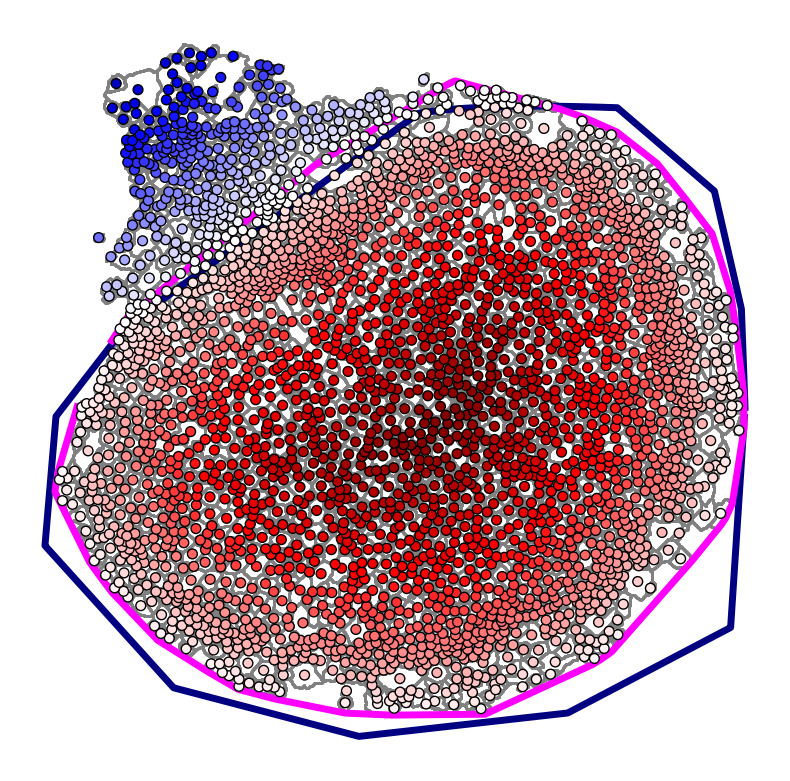

In [60]:
fig, ax = plt.subplots(1,1,figsize=(8,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=1, c='gray', zorder=1)
ax[0].plot(hull[:,0], hull[:,1], lw=5, c='navy', zorder=2)
ax[0].plot(bhull[:,0], bhull[:,1], lw=5, c='magenta', zorder=4)
ax[0].scatter(coms[1:,0], coms[1:,1], marker='o', s=50, c=ecc[1:], edgecolor='k', zorder=5, vmax=vmax, vmin=-vmax, cmap='seismic')

ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].set_facecolor('dimgray')
fig.tight_layout();

#plt.savefig(wsrc + 'eccentricity_root_nodule.png', dpi=200, format='png', bbox_inches='tight')

In [65]:
eccentricity = pd.DataFrame(index=metacell.index)
eccentricity['inside_hull'] = inhull
eccentricity['eccentricity'] = ecc
eccentricity.to_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index=True)

eccentricity.head()

,inside_hull,eccentricity
ndimage_cellID,,
1,False,-0.000000
2,True,250.002000
3,True,156.000000
4,True,127.000000
5,True,231.036794


# Color Cell IDs

In [5]:
sample = 'B2'

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
ksrc = '../kde/'
dst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

ksrc += sample + os.sep
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='orig_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))


In [6]:
xlsxname = 'RootCellTypeAssignment'

#xlsxname = 'D2.Cell.I.D.Assignments'
data = pd.read_excel(csrc + xlsxname + '.xlsx', sheet_name=sample).drop(labels=0, axis=0)
dcolors = [ '#' + data.columns[i][:-1].split('(')[1] for i in range(data.shape[1]) ]
print(dcolors)
cmap = ListedColormap(['#bbbbbb', '#ffffff'] + dcolors)
data

['#09C8F7', '#AB24B1', '#F4C8A1', '#FB8E01', '#BB4918', '#BE9146']


,Epidermis (09C8F7),Cortex (AB24B1),Cambium (F4C8A1),Pericycle (FB8E01),Xylem (BB4918),Phloem (BE9146)
1,432.0,4,161.0,85.0,248.0,97.0
2,471.0,5,205.0,86.0,289.0,112.0
3,535.0,6,207.0,87.0,313.0,129.0
4,742.0,7,237.0,88.0,322.0,134.0
5,1068.0,8,253.0,89.0,334.0,136.0
...,...,...,...,...,...,...
221,NaN,1219,NaN,NaN,NaN,NaN
222,NaN,1221,NaN,NaN,NaN,NaN
223,NaN,1222,NaN,NaN,NaN,NaN
224,NaN,1225,NaN,NaN,NaN,NaN


../cell_dams/B2_RootCellTypeAssignment.png


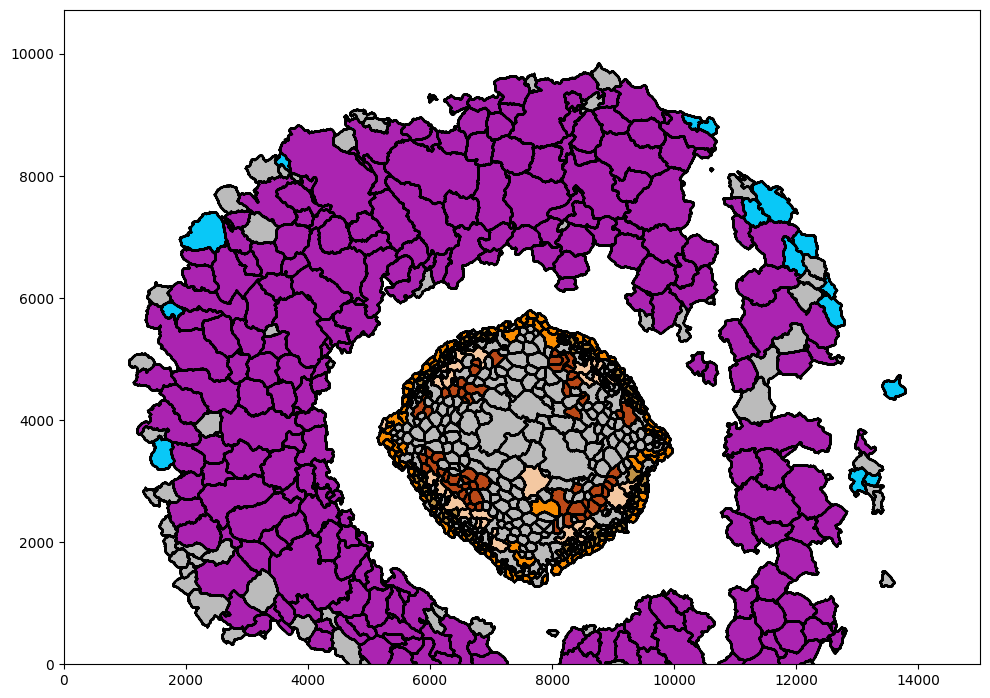

In [8]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(wall, cmap=cmap, zorder=1, origin='lower')
ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=0.1, c='k', zorder=2)

ax[0].set_aspect('equal')
fig.tight_layout();
filename = wsrc + sample + '_' + xlsxname + '.png'
print(filename)
plt.savefig(filename, dpi=200, format='png', bbox_inches='tight')

In [2]:
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
ksrc = '../kde/'
dst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
fs = 20

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
xlsxname = 'RootCellTypeAssignment'

for sample in ['A1', 'A2', 'B1', 'B2']:
    ksrc = '../kde/' + sample + os.sep
    metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='orig_cellID')
    metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
    transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
    wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
    wcoords = np.asarray(np.nonzero(~wall))
    wallshape = wall.shape
    label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
    css = ndimage.find_objects(label)
    data = pd.read_excel(csrc + xlsxname + '.xlsx', sheet_name=sample).drop(labels=0, axis=0)
    dcolors = [ '#' + data.columns[i][:-1].split('(')[1] for i in range(data.shape[1]) ]
    cmap = ListedColormap(['#bbbbbb', '#ffffff'] + dcolors)

    wall = np.zeros(wallshape, dtype=int)
    for i in range(data.shape[1]):
        idx =  data.loc[~pd.isna(data.iloc[:,i])].iloc[:,i].values.astype(int)
        idx = idx[idx <= metacell.iloc[-1].name ]
        
        for val in metacell.loc[list(set(idx) & set(metacell.index))]['ndimage_cellID'].values:
            wall[css[val-1]][label[css[val-1]] == val] = i+2
    wall[label == 1] = 1
    
    fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    ax[0].imshow(wall, cmap=cmap, zorder=1, origin='lower')
    ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=0.1, c='k', zorder=2)
    
    ax[0].set_aspect('equal')
    fig.tight_layout();
    filename = wsrc + sample + '_' + xlsxname + '.png'
    print(filename)
    plt.savefig(filename, dpi=200, format='png', bbox_inches='tight')
    plt.close()

../cell_dams/A1_RootCellTypeAssignment.png
../cell_dams/A2_RootCellTypeAssignment.png
../cell_dams/B1_RootCellTypeAssignment.png
../cell_dams/B2_RootCellTypeAssignment.png


In [143]:
filename = '../infected_focus_summer24/D2/infected_cells_ids'
cells = pd.read_csv(filename + '.csv')

N = 125
for i in range(10):
    cells.loc[i*N:i*N + N - 1].to_csv(filename + '_{:02d}.csv'.format(i), index=False)

# Deal with transcripts on the edge